## Libraries

In [4]:
# !pip install tslearn
# !pip install yfinance
# !pip install tsfresh
# !pip install stumpy 
# !pip install statsmodels==0.11.1
# !pip install python-dateutil=2.7.3 
# !pip install scipy==1.5
# !pip install numba==0.54

In [5]:
import numba
import stumpy

import plotly.graph_objs as go

import yfinance as yf

import pandas as pd
import numpy as np

import datetime  

import matplotlib.pyplot as plt

import seaborn as sns

import tqdm
from tqdm import tqdm
import tslearn

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features, feature_extraction
from tsfresh.feature_extraction import settings

from sklearn.feature_selection import VarianceThreshold

## Functions 

In [9]:
def Candlestick_month(symbol, name):
    ''' Returns the candlestick graph dynamics per month
  
    Parameters
    ----------
    symbol: str
        ticker symbol for a company 
    name: str
        company name for a graph
    
    '''

    fig = go.Figure()

    asset = yf.download(tickers=symbol, period = '1mo', interval = '1d')
    #Candlestick
    fig.add_trace(go.Candlestick(x=asset.index,
                    open=asset['Open'],
                    high=asset['High'],
                    low=asset['Low'],
                    close=asset['Close'], name = 'market data'))

    # Add titles
    fig.update_layout(
        title= f'{name} live share price evolution',
        yaxis_title= f'{name} Price (kUS Dollars)')

    #Show
    fig.show()

In [10]:
# Candlestick graph dynamics per day

def Candlestick(symbol, name):
    ''' Returns the candlestick graph dynamics per day
  
    Parameters
    ----------
    symbol: str
        ticker symbol for a company 
    name: str
        company name for a graph
    
    '''

    fig = go.Figure()

    asset = yf.download(tickers=symbol, period = '22h', interval = '15m')
    #Candlestick
    fig.add_trace(go.Candlestick(x=asset.index,
                    open=asset['Open'],
                    high=asset['High'],
                    low=asset['Low'],
                    close=asset['Close'], name = 'market data'))

    # Add titles
    fig.update_layout(
        title= f'{name} live share price evolution',
        yaxis_title= f'{name} Price (kUS Dollars)')

    # X-Axes
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=15, label="15m", step="minute", stepmode="backward"),
                dict(count=45, label="45m", step="minute", stepmode="backward"),
                dict(count=1, label="HTD", step="hour", stepmode="todate"),
                dict(count=6, label="6h", step="hour", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    #Show
    fig.show()

In [13]:
#Information about an asset

def crypto_info(symbol, year_start=2021, month_start=1, day_start=1, year_end=2021, month_end=11, day_end=14):
    ''' Returns the information about the company's stock price
  
    Parameters
    ----------
    symbol: str
        ticker symbol for a company 
    year_start: int
        year when the analysis begins [default=2021]
    month_start: 
        month when the analysis begins [default=1]
    day_start:
        day when the analysis begins [default=1]
    year_end:
        year when the analysis ends [default=2021]
    month_end:
        month when the analysis ends [default=11]
    day_end: 
        day when the analysis ends [default=14]
    '''

    start = datetime.datetime(year_start, month_start, day_start)
    end = datetime.datetime(year_end, month_end, day_end) 

    asset_info = yf.download(symbol, start=start, end=end)
    return asset_info

In [15]:
def visualize_cluster(current_cluster, df):
    ''' Returns the graph with a chosen cluster
  
    Parameters
    ----------
    current_cluster: int
        cluster for visulaization
    df: dataframe
        dataframe with clusters 
    '''
    list_asset = [asset for asset in df.index if df.loc[asset, 'clusters'] == current_cluster]          
    print(f'There are {len(list_asset)} in {current_cluster} cluster')
    for i in range(df.shape[0]): #fig, ax = plt.subplots(,3)
        line = df['clusters'][i]
        if line == current_cluster:
            plt.plot(df.iloc[i, :-1])
            plt.xticks(rotation=45)
            plt.title(df.index[i])
            plt.show()

## Crypto Analysis

Top cryptos by market cap were selected [09/07/2022]
source: [yahoo-finance watchlist](https://finance.yahoo.com/u/yahoo-finance/watchlists/crypto-top-market-cap/)

In [152]:
html_df = pd.read_html('/content/stocks_data.html')[1]

In [37]:
cryptos = list(html_df['Symbol'])

## DataFrame with closing prices of cryptos

In [ ]:
start = datetime.datetime(2021, 1, 10)
end = datetime.datetime(2021, 7, 8)

assets = pd.DataFrame()
for i in cryptos:
  assets[i] = yf.download(i, start=start, end=end)['Close']

In [39]:
assets.tail()

,BTC-USD,ETH-USD,USDT-USD,USDC-USD,BNB-USD,BUSD-USD,XRP-USD,ADA-USD,SOL-USD,DOGE-USD,...,UNI1-USD,YOUC-USD,STETH-USD,FTT-USD,LTC-USD,CRO-USD,LINK-USD,XLM-USD,NEAR-USD,ATOM-USD
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-04,35287.781250,2321.724121,0.999501,0.999500,307.732086,0.999373,0.694945,1.458184,34.310600,0.246483,...,20.771873,0.052906,2321.341064,27.449049,144.905853,0.122427,19.262838,0.268128,2.291444,12.263548
2021-07-05,33746.003906,2198.582520,1.000667,1.000528,302.377991,1.000414,0.654300,1.404898,32.984589,0.231614,...,20.095181,0.069485,2204.333740,25.368855,138.073242,0.115814,18.371590,0.254456,2.172307,13.548475
2021-07-06,34235.195312,2324.679443,1.000090,1.000059,320.934814,1.000021,0.665402,1.418053,34.269138,0.234422,...,22.400187,0.068797,2324.837158,28.817072,138.985641,0.122856,20.080465,0.260190,2.259642,13.159371
2021-07-07,33855.328125,2315.161865,1.000708,1.000370,327.522461,1.000484,0.651575,1.403118,36.591370,0.224126,...,22.231146,0.064618,2307.621338,30.022102,137.371216,0.119605,19.764128,0.256940,2.294410,12.926386
2021-07-08,32877.371094,2120.026367,0.999900,0.999945,310.427124,0.999917,0.623058,1.330146,33.203728,0.207597,...,20.400131,0.061079,2126.748535,28.761093,132.308502,0.114718,18.422050,0.243421,2.104819,11.928683


## Examples

**Crypto_info() function** 

In [40]:
crypto_info('ETH-USD').tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,4733.362793,4859.502930,4485.093262,4636.174316,4636.174316,22748160545
2021-11-11,4635.453613,4778.059082,4580.990234,4730.384277,4730.384277,17933201129
2021-11-12,4724.306641,4808.738770,4510.920410,4667.115234,4667.115234,18316060208
2021-11-13,4666.719238,4702.115234,4582.180664,4651.460449,4651.460449,14457436261
2021-11-14,4648.632812,4689.842773,4516.935547,4626.358887,4626.358887,12172962219


**Candlestick_month() function**

In [41]:
eth = pd.DataFrame(crypto_info('ETH-USD')['Close'])

[*********************100%***********************]  1 of 1 completed


In [43]:
eth.head()

,Close
Date,
2021-01-01,730.367554
2021-01-02,774.534973
2021-01-03,975.507690
2021-01-04,1040.233032
2021-01-05,1100.006104


Percentage change between the current and a prior prices.

In [44]:
eth['return'] = eth.Close.pct_change()

In [46]:
eth.head()

,Close,return
Date,,
2021-01-01,730.367554,NaN
2021-01-02,774.534973,0.060473
2021-01-03,975.507690,0.259475
2021-01-04,1040.233032,0.066350
2021-01-05,1100.006104,0.057461


In [47]:
Candlestick_month('ETH-USD', 'Ethereum')

[*********************100%***********************]  1 of 1 completed


**Candlestick() function**

In [48]:
Candlestick('ETH-USD', 'Ethereum')

[*********************100%***********************]  1 of 1 completed


## Clusterization

1. Cluserization using Kmeans without generated features
2. Cluserization using Kmeans with generated features





### 1. Cluserization using Kmeans without generated features

Create new dataframe assets_norm with normalized assets

In [49]:
assets.fillna(0, inplace=True)

In [50]:
scaled_data = StandardScaler().fit_transform(assets).T

Definition of a number of clusters

*   Analysis of SSE and silhoette
*   Definition of the number of clusters



The higher silhouette - the better <br>
The lower SSE - the better

100%|██████████| 9/9 [00:00<00:00, 37.58it/s]


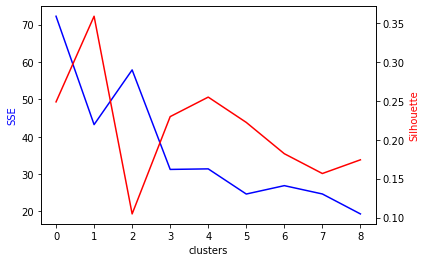

In [158]:
sse = []
silhouette = []
K = range(2, 11)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric='euclidean', init='random', max_iter=300)
    kmeanModel.fit(scaled_data)
    sse.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(scaled_data, kmeanModel.labels_, metric='euclidean'))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sse, 'b-')
ax2.plot(silhouette, 'r-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('SSE', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

Number of clusters chosen: 5

In [52]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', init='random', max_iter=300)
ts_kmeans.fit(scaled_data) #predicting cluster of the assets given 

TimeSeriesKMeans(init='random', max_iter=300, n_clusters=5)

Visualization of cluster centroids

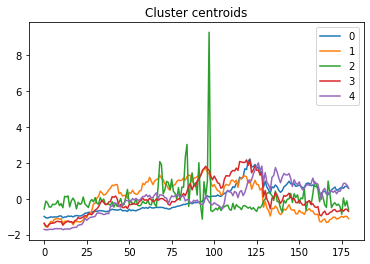

In [53]:
for cluster in range(n_clusters):
  plt.plot(ts_kmeans.cluster_centers_[cluster, :, 0], label=cluster)
plt.title('Cluster centroids')
plt.legend()
plt.show()

Addition of a column **clusters** to the dataframe assets_transposed

In [76]:
assets_transposed = assets.T

In [77]:
assets_transposed['clusters'] = ts_kmeans.predict(scaled_data)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries



Cryptos' visualization in the particular cluster

There are 4 in 2 cluster


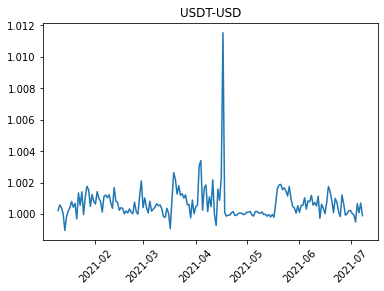

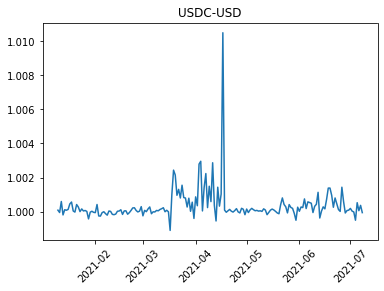

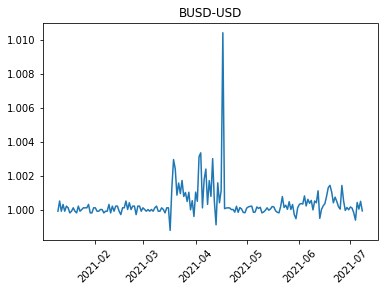

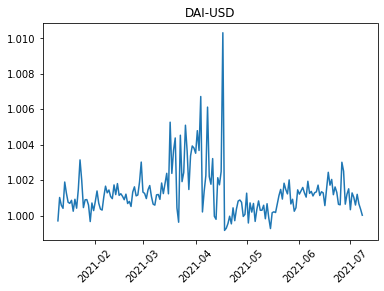

In [79]:
visualize_cluster(2, assets_transposed)

### 2. Cluserization using Kmeans with generated features

Normalization of assets <br> $z=\frac{(x_i - \overline {x})} {σ}$


In [108]:
norm_assets = assets.copy()
norm_assets.fillna(norm_assets.mean(), inplace=True)
norm_assets.drop('WTRX-USD', axis=1, inplace=True)

In [109]:
for column_ in norm_assets.columns:
  for i in range(norm_assets.shape[0]):
      norm_assets[column_][i] = (norm_assets[column_][i] - np.nanmean(norm_assets[column_])) / np.std(norm_assets[column_])

In [111]:
norm_assets_tr = norm_assets.T.copy()

In [112]:
norm_assets_tr['crypto'] = norm_assets_tr.index

In [113]:
assets_tr = assets.T.copy()

Addition of relevant parameters

In [114]:
settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())


Feature generation 

In [115]:
EXTRACT = True

if EXTRACT:
    x_norm = extract_features(norm_assets_tr, settings_efficient, column_id='crypto')
 # column_id=norm_assets_tr.index)
    x_norm.to_csv('X_train_tsfel_norm.csv')
else:
    x_norm = pd.read_csv('X_train_tsfel_norm.csv', index_col=0)

x_norm.shape


Feature Extraction: 100%|██████████| 5220/5220 [00:10<00:00, 511.87it/s]


(29, 2340)

2340 features were generated <br>

Tasks:
*   Drop NaN  
*   Drop duplicate columns 
*   Drop columns with the opposite sign




*   Drop NaN




In [116]:
x_norm.dropna(inplace=True, axis=1)

In [117]:
x_norm.shape

(29, 1980)

*   Drop duplicates: their corr = +1 
*   Drop columns with the opposite sign: their corr = -1 



In [124]:
x_red = x_norm.T.drop_duplicates(ignore_index=True).T

In [125]:
x_red_pos = x_red[(x_red > 0)].dropna(axis=1)

In [126]:
x_red_pos.shape

(29, 181)

There are 181 generated features without duplicates and NaN

Features with a variance lower than the threshold are removed

In [127]:
selector = VarianceThreshold()
X_reduced_pos = selector.fit_transform(x_red_pos)


180 features left

In [128]:
X_reduced_pos.shape

(29, 180)

*   Analysis of SSE and silhoette
*   Definition of the number of clusters


100%|██████████| 9/9 [00:00<00:00, 43.88it/s]


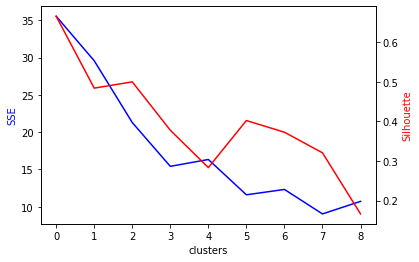

In [132]:
sse = []
silhouette = []
K = range(2, 11)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric='euclidean', init='random', max_iter=300)
    kmeanModel.fit(X_reduced_pos)
    sse.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(X_reduced_pos, kmeanModel.labels_, metric='euclidean'))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sse, 'b-')
ax2.plot(silhouette, 'r-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('SSE', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()


Number of clusters = 5

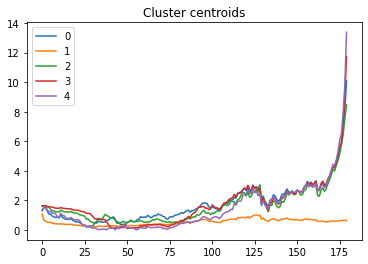

In [133]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', init='random', max_iter=300)
ts_kmeans.fit(X_reduced_pos) #predicting cluster of the assets given 

for cluster in range(n_clusters):
  plt.plot(ts_kmeans.cluster_centers_[cluster, :, 0], label=cluster)
plt.title('Cluster centroids')
plt.legend()
plt.show()

Addition of a column **crypto** with predicted classes to **assets_features_pos** dataframe

In [134]:
x_red_pos['clusters'] = ts_kmeans.predict(X_reduced_pos)
assets_features_pos = assets_tr.join(x_red_pos[['clusters']])

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 29 1-dimensional timeseries



Visualization of the clusterization with generated features

There are 2 in 4 cluster


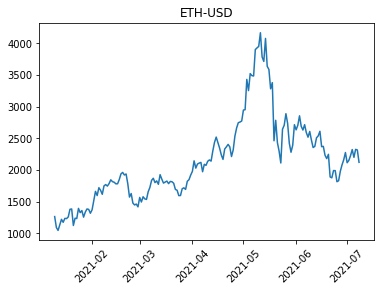

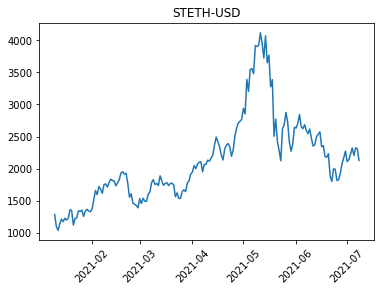

In [135]:
visualize_cluster(4, assets_features_pos)